# SkimLit exercises
Exercises from @mrdbourdke course, all solution are either code-alongs (if already created) or proposed my myself.

## Exercise 1
Train `model_5` from notebook 09 on all of the data in the training dataset as many epochs until it stops improving. Since this might take a while, consider using:
* `tf.keras.callbacks.ModelCheckpoint` to save weights of the best model trained
* `tf.keras.callbacks.EarlyStopping` to stop the model from training once the validation less has stopped improving for approx. 3 epochs

### Confirm GPU access

In [2]:
!nvidia -smi

/bin/bash: nvidia: command not found


### Get the data

In [1]:
# Clone the GitHub repo and 
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 10.45 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [5]:
# Get the full, 200k dataset
data_dir = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Check the filenames in the directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt']

In [ ]:
# Download helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [12]:
# Unzipping the data
from helper_functions import unzip_data
unzip_data("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip")

### Preprocess the data

In [7]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (text file) and returns the lines of text as a list.

  Args:
    filename: string, contains the target filepath

  Returns:
    A list of strins with one string per line from the target filename
  """

  with open(filename, 'r') as f:
    return f.readlines()

In [13]:
# Reading in the training lines
train_lines = get_lines('train.txt')
train_lines[:10]

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n",
 'METHODS\tThe program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .\n',
 'METHODS\tParticipants will access the program f

In [14]:
# Get the total number of lines
len(train_lines)

2593169

In [17]:
# Function to preprocess the data to desired format
def preprocess_text_with_linenumbers(filename):
  """
  Returns a list of dictionaries of abstract RCT line data. Takes in the filename,
  reads its content and works through each line extracting all necessary data to
  be returned,

  Args:
    filename: string, contains a RCT data 

  Returns:
    abstract_samples: dictionary, with data such as 'target', 'text',
      'line_number' and 'total_lines' per each abstract
  """
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"): # check for the ID of an abastract
      abstract_id = line
      abstract_lines = "" # reset the abstract string so it's empty for new one

    elif line.isspace(): # check if the line is the new line
      abstract_line_split = abstract_lines.splitlines() # split the lines into new lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split the text from the target label
        line_data['target'] = target_text_split[0] # get the target label
        line_data['text'] = target_text_split[1].lower() # get the text in lowered version
        line_data['line_number'] = abstract_line_number # get the number of a particular line from enumerate operator
        line_data['total_lines'] = len(abstract_line_split)-1 # how many total lines are there in each abstract

        abstract_samples.append(line_data) # add the data to the samples list

    else: # if the above are not met, the line contains labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [18]:
# Get the data into the memory
%%time
train_samples = preprocess_text_with_linenumbers('train.txt')
val_samples = preprocess_text_with_linenumbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_linenumbers(data_dir + 'test.txt')
print(len(train_samples), len(val_samples), len(test_samples))

2211861 28932 29493
CPU times: user 4.48 s, sys: 823 ms, total: 5.31 s
Wall time: 5.73 s


In [19]:
# Check the first samples from training data
train_samples[:15]

[{'target': 'BACKGROUND',
  'text': 'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'line_number': 0,
  'total_lines': 10},
 {'target': 'BACKGROUND',
  'text': 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
  'line_number': 1,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
  'line_number': 2,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': "the intervention group will participate in the online group program ` positive outlook ' .",
  'line_number': 3,
  'total_lines': 10},
 {'target': 'METHODS',
  '

In [21]:
# Placing the data in Pandas DataFrame
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(15)

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10
5,METHODS,participants will access the program for a min...,5,10
6,METHODS,primary outcomes are domain specific self-effi...,6,10
7,METHODS,"secondary outcomes include : depression , anxi...",7,10
8,METHODS,"data collection will take place at baseline , ...",8,10
9,CONCLUSIONS,results of the positive outlook study will pro...,9,10


### Small portion of EDA

<Axes: >

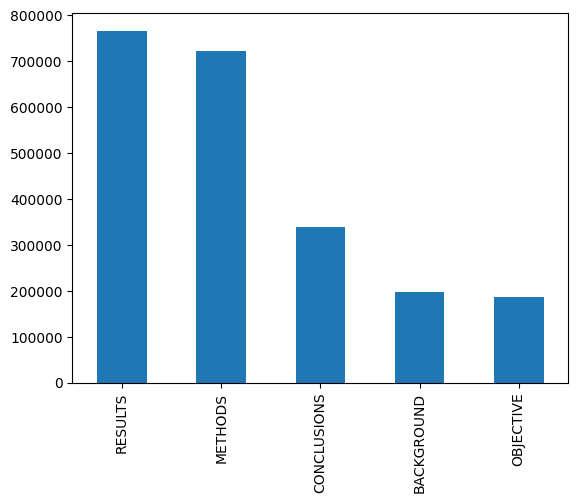

In [25]:
# Distribution of training labels
train_df['target'].value_counts().plot(kind='bar')

<Axes: ylabel='Frequency'>

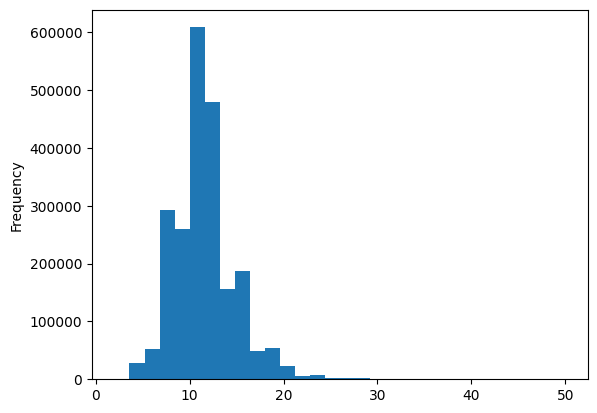

In [27]:
# Checking the number of lines per abstract
train_df.total_lines.plot.hist(bins=30)

### Getting the list of sentences

In [28]:
# Extracting the lines from DataFrames
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()
print(len(train_sentences))

2211861


### Encode the labels
Both one-hot-encoded and label encoded (numerical value)

In [44]:
# One-hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

# Check one set of labels
train_labels_one_hot[:20]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [45]:
# Label encode labels (numerical values)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# Check the labels
train_labels_encoded[:20]

array([0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 2, 2, 2, 4, 4, 4, 4, 4])